In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# 9. Supervised Learning
## 9-1 의사결정나무와 앙상블
### 9-1-1 의사결정나무
- 최종 결정을 위해 예/아니오 질문을 이어나가면서 학습하는 알고리즘
- 예측변수 값을 기준으로 데이터를 반복적으로 분할해 나가는데 이렇게 만들어진 분할 영역을 통해 0 또는 1의 결과를 예측, 회귀의 경우 도달한 리프노드 내에 있는 데이터 평균값 예측
- greedy heuristic : 트리의 루트에서부터 정보를 가장 많이 포함한, 가장 높은 정보 획득(information gain) 값을 주는 피쳐를 각 단계에서 선택해나감, 데이터의 불순도가 최대로 줄어드는 것

[불순도의 종류]
- 엔트로피 : 피쳐들의 집합에 존재하는 불순도의 양, 0에 가까울 수록 불순도가 낮음
$$ -\sum^m_{i=1}(P_i)*log_2(P_i)\quad,\ p:\frac{리프노드\ 내\ 전체\ 데이터의\ 개수$}{해당\ 클래스\ 개수},\ m : 클래스\ 종류\ 개수$$
- 지니 불순도 : 0에 가까울수록 불순도가 낮음, 각 클래스가 나올 확률에 제곱합을 1에서 빼면 지니불순도
$$ 1-\sum^m_{i=1}(P_i)\quad,\ p:\frac{리프노드\ 내\ 전체\ 데이터의\ 개수$}{해당\ 클래스\ 개수},\ m : 클래스\ 종류\ 개수$$
  - 지니 계수와 다름 : 지니계수는 이진분류 한정이며 AUC관련 지표
- 편차 제곱합 : 리프 노드에 있는 데이터들이 가장 작은 편차 제곱합을 갖도록 데이터 분할

[특성 중요도]
- 트리를 만드는 결정에 각 피쳐가 얼마나 사용되었는가.
- 특성 중요도의 전체 합은 1. 항상 양수(어떤 클래스를 지지하는지[분류], 양/음 관계 여부[회귀]는 알 수 없음)
- 어떤 특성의 중요도가 낮다고 해서 이 피쳐가 유용하지 않다는 게 아니라, 단지 다른 피쳐도 동일정보를 지니고 있어서 트리가 분기할 때 해당 피처를 선택하지 않았을 수 있음

[의사결정나무 장단점]
- 장점
    - 계산 비용이 n개의 데이터에 대해 log(n)으로 매우 낮음
    - 트리를 따라 내려오다보면 해석이 쉽고 시각화 가능
    - 데이터 스케일에 구애받지 않아, 표준화 필요 없음
    - 범주형, 연속형 변수가 혼합되어도 잘 동작 & 이상치나 결측치 잘 대처
- 단점
    - 필요없더라도 주어진 모든 특성을 사용하므로 과적합의 위험
    => 트리 크기 제한, early stopping, validation data
    - 모델의 데이터 범위 밖으로 나가면 새로운 데이터 예측이 불가능. 시계열 데이터에 잘 맞지 않음
    
[과적합 제어 전략]
- 트리 생성 일찍 중단 : 트리 최대 깊이나 리프의 최대 개수를 제한하거나, 노드가 분할할 데이터의 최소개수 지정
- 트리를 만든 후 데이터 포인트가 적은 노드 삭제하거나 병합

In [2]:
from collections import Counter

def entropy(data):
    if type(data[0]) == float: # class별 확률 입력하는 경우
        ratio = np.array(data)
        value = -(ratio * np.log2(ratio)).sum()
    else:
        counts = Counter(data) # 범주형 데이터
        m = np.array(list(counts.keys()))
        freq = np.array(list(counts.values()))
        total = freq.sum()
        ratio = freq/total
        value = -(ratio * np.log2(ratio)).sum()
    return value

def gini(data):
    if type(data[0]) == float: # class별 확률 입력하는 경우
        ratio = np.array(data)
        value = 1-(ratio**2).sum()
    else:
        counts = Counter(data) # 범주형 데이터
        m = np.array(list(counts.keys()))
        freq = np.array(list(counts.values()))
        total = freq.sum()
        ratio = freq/total
        value = 1 - (ratio**2).sum()
    return value

In [3]:
print('[binary class data]')
bi_result = ['A', 'A', 'A', 'B', 'B']
e1 = entropy(bi_result)
e2 = entropy([3/5, 2/5])
print(f"entropy: {e1:.2f}, ({e1:.2f})")

g1 = gini(bi_result)
g2 = gini([3/5, 2/5])
print(f"gini: {g1:.2f}, ({g2:.2f})")

[binary class data]
entropy: 0.97, (0.97)
gini: 0.48, (0.48)


Tree score: 0.944


findfont: Font family ['D2Coding'] not found. Falling back to DejaVu Sans.


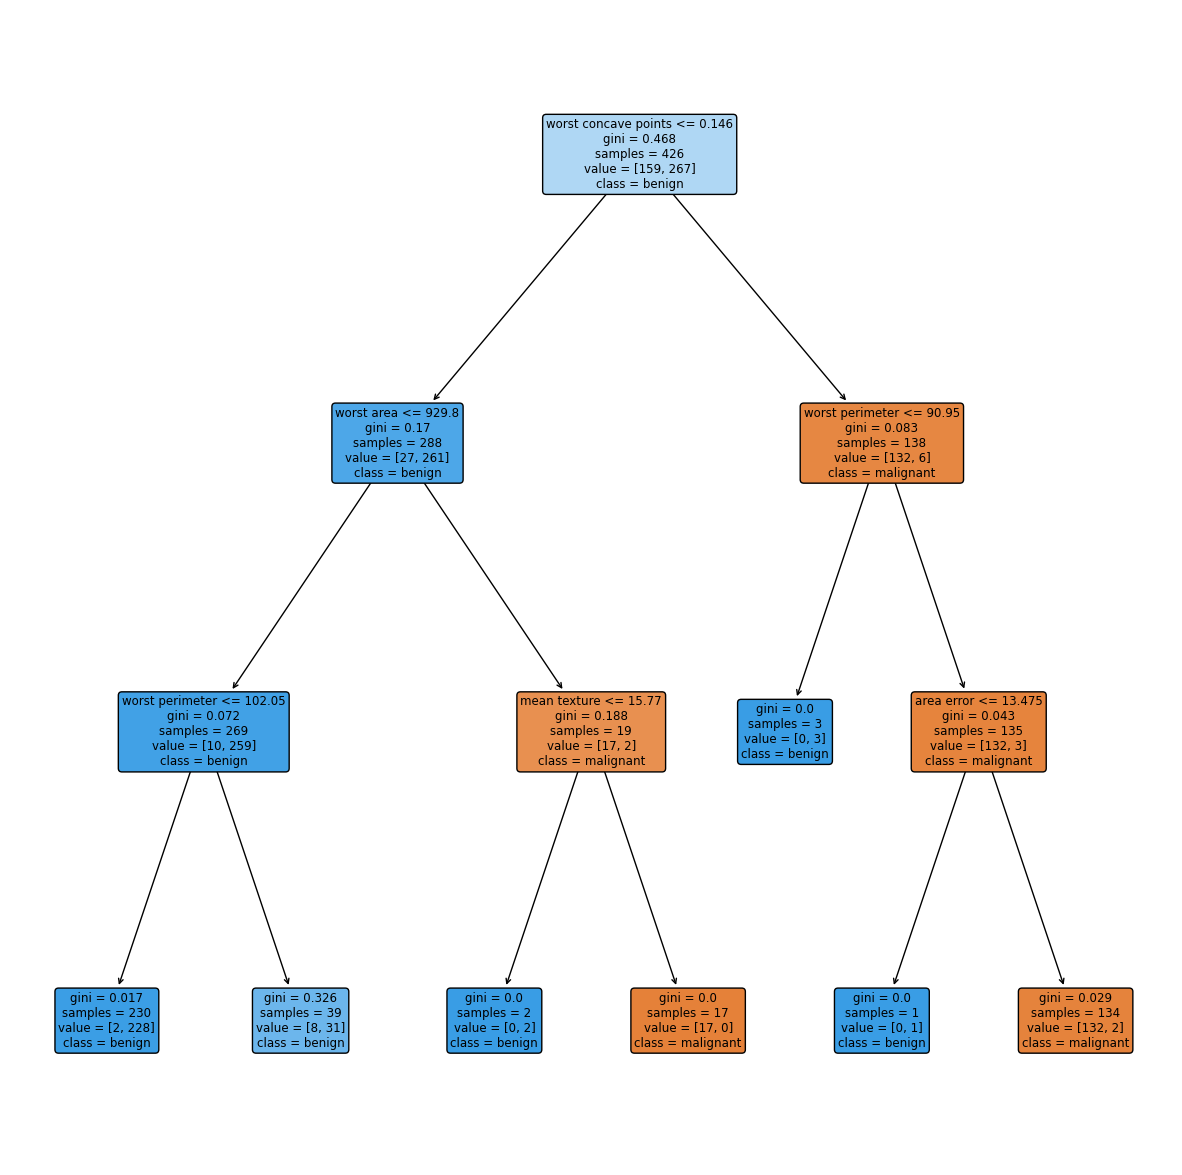

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (15,15)
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

tree = DecisionTreeClassifier(max_depth=3, criterion='gini')
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
print(f"Tree score: {tree.score(X_test, y_test):.3f}")

plot_tree(tree, class_names=cancer.target_names, feature_names=cancer.feature_names, impurity=True, filled=True, rounded=True)
plt.show()

In [6]:
print(export_text(tree))

|--- feature_27 <= 0.15
|   |--- feature_23 <= 929.80
|   |   |--- feature_22 <= 102.05
|   |   |   |--- class: 1
|   |   |--- feature_22 >  102.05
|   |   |   |--- class: 1
|   |--- feature_23 >  929.80
|   |   |--- feature_21 <= 19.91
|   |   |   |--- class: 1
|   |   |--- feature_21 >  19.91
|   |   |   |--- class: 0
|--- feature_27 >  0.15
|   |--- feature_20 <= 12.80
|   |   |--- class: 1
|   |--- feature_20 >  12.80
|   |   |--- feature_13 <= 13.47
|   |   |   |--- class: 1
|   |   |--- feature_13 >  13.47
|   |   |   |--- class: 0



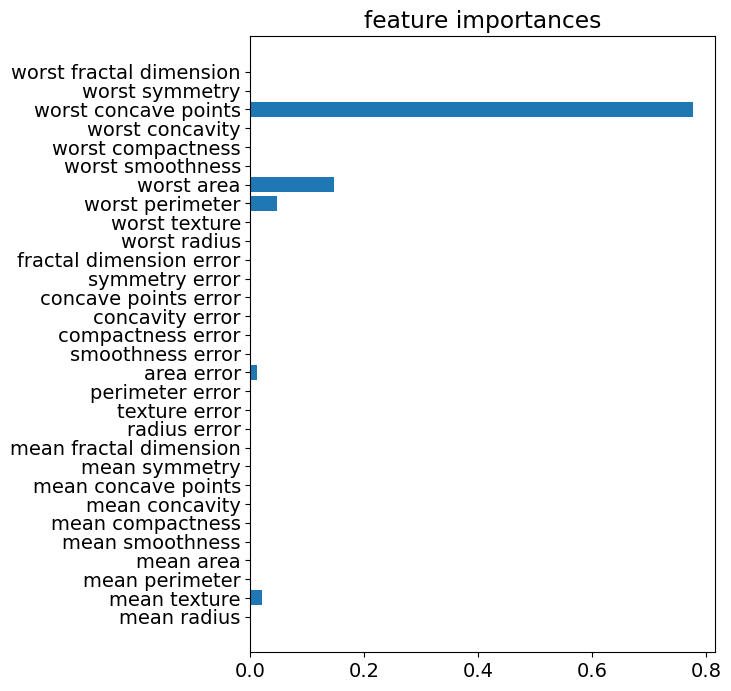

In [9]:
plt.subplots(1, 1, figsize=(6,8))
fi = tree.feature_importances_
fn = cancer.feature_names
plt.title("feature importances")
plt.barh(fn, fi)
plt.show()

### 9-1-2 앙상블
- 많은 학습모델ㅇ르 통해 데이터에 대해 서로 조금씩 다른 결과들을 얻고 이를 종합
- 최종 예측값을 얻기 위해 여러 모델들의 예측값을 바탕으로 voting
    - hard voting : 예측값을 바탕으로 다수결 투표
    - soft voting : 예측값들의 평균 또는 가중치 합
    - stacking : 예측값을 피쳐로 삼고, 실제값을 타겟으로 하여 새로운 모델 생성 후 최종 예측
    
### 배깅    
- 중복을 허용한 랜덤샘플링으로 원본과 동일한 크기의 여러 훈련 세트를 만들고 각각 학습 시킨 후 집계
- 샘플링은 일반적으로 원본 데이터의 반사용
- robust bagging : 회귀할 때 이상치의 영향을 많이 받으므로 평균 대신 중위수를 사용하기도 함 
- 부트스트랩 샘플 특성 상, 어떤 데이터는 중복 포함되는 반면, 어떤 데이터는 36.8% 확률로 포함되지 않을 수 있음 => OOB 샘플

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
print("data shape: ", X.shape)
print(f"train size: {len(X_train)}, test size: {len(X_test)}")


data shape:  (569, 30)
train size: 426, test size: 143


In [14]:
estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
bagging = BaggingClassifier(estimator, n_estimators=50, oob_score=True, n_jobs=-1, 
                           random_state=0, max_samples=1.0, max_features=1.0)
bagging.fit(X_train, y_train)
bagging_pred = bagging.predict(X_test)
bagging_prob = bagging.predict_proba(X_test)[:, 1]

print(f'train set acc: {bagging.score(X_train, y_train):.3f}')
print(f'test set acc: {bagging.score(X_test, y_test):.3f}')
print(f'train set acc: {bagging.oob_score_:.3f}')

train set acc: 0.977
test set acc: 0.923
train set acc: 0.955


In [19]:
print(f"첫번쨰 estimator의 bootstrap 샘플 수 {len(bagging.estimators_samples_[0])}, 원본 훈련샘플 수 {len(X_train)}")
print(f"첫번쨰 estimator의 bootstrap 샘플 수 {len(bagging.estimators_features_[0])}, 원본 훈련샘플 수 {X_train.shape[1]}")


첫번쨰 estimator의 bootstrap 샘플 수 426, 원본 훈련샘플 수 426
첫번쨰 estimator의 bootstrap 샘플 수 30, 원본 훈련샘플 수 30


### 부스팅
- 학습할 떄마다 잔차가 큰 데이터포인트들의 가중치를 높여가며 일련의 모델 생성.
- 이전 모델이 갖는 오차를 줄이는 방향으로 다음 모델을 순차적으로 생성

[Adaptive boosting]
- 잔차에 따라 데이터의 가중치를 조절하는 부스팅의 초기버전
- 앞서 생성한 학습자가 예측한 결과와 차이가 클수록 해당 데이터는 높은 가중치
- 각 데이터마다 얻어진 가중치들은 다음 학습자가 학습할 때 입력값의 일부로 주어짐. 
- 매 반복 마다 가중치는 업데이트 되며, 예측하기 어려운 데이터에 대해 더 집중해서 학습하도록 모델 생성

[Gradient Boosting]
- 전체 데이터의 오차를 최적화하는 접근법 사용
- 가중치를 조정하는 대신 모델이 유사 잔차를 학습. 이 때 잔차가 그래디언트로 표현되며, 경사하강법을 사용하여, 다음에 추가될 트리가 예측해야 할 값ㅇ르 보정
- max_depth는 일반적으로 5이하, learning_rate로 모델의 복잡성 제어

[Stochastic gradient boosting]
- 학습할 때마다 데이터와 예측변수를 샘플링하는 식으로 그래디언트 부스팅에 랜덤요소 추가

train set acc: 1.000
test set acc: 0.944


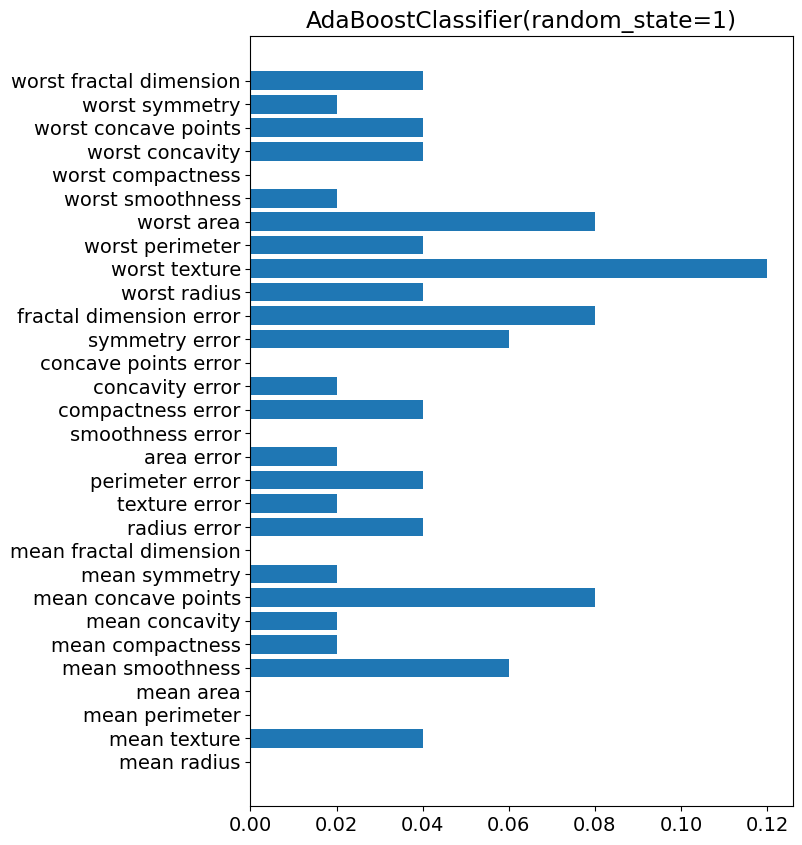

In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=1, n_estimators=50)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
ada_prob = ada.predict_proba(X_test)[:, 1]

print(f"train set acc: {ada.score(X_train, y_train):.3f}")
print(f"test set acc: {ada.score(X_test, y_test):.3f}")

fi = ada.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(ada)
plt.barh(fn, fi)
plt.show()

train set acc: 1.000
test set acc: 0.951


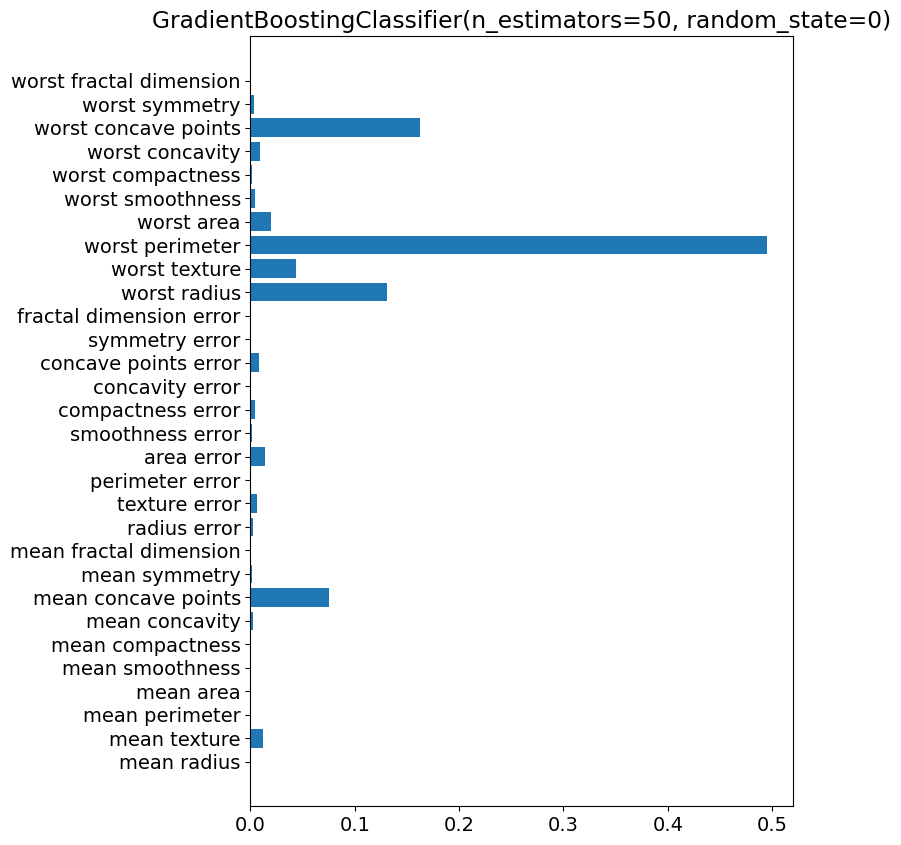

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=0, n_estimators=50)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
gbc_prob = gbc.predict_proba(X_test)[:, 1]

print(f"train set acc: {gbc.score(X_train, y_train):.3f}")
print(f"test set acc: {gbc.score(X_test, y_test):.3f}")

fi = gbc.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(gbc)
plt.barh(fn, fi)
plt.show()

train set acc: 0.998
test set acc: 0.923


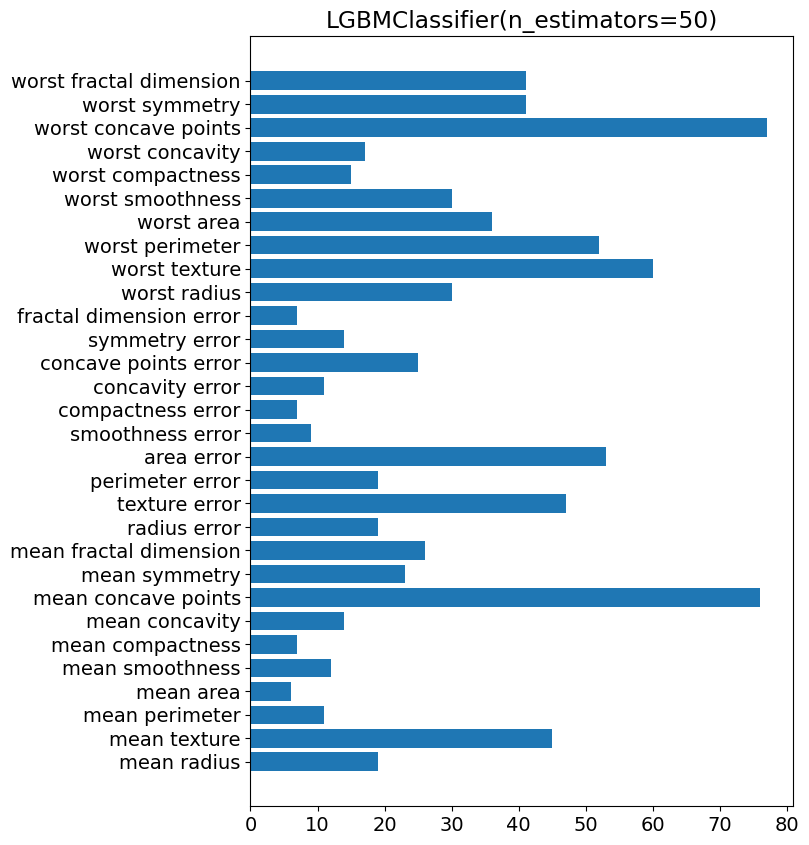

ImportError: You must install graphviz to plot tree.

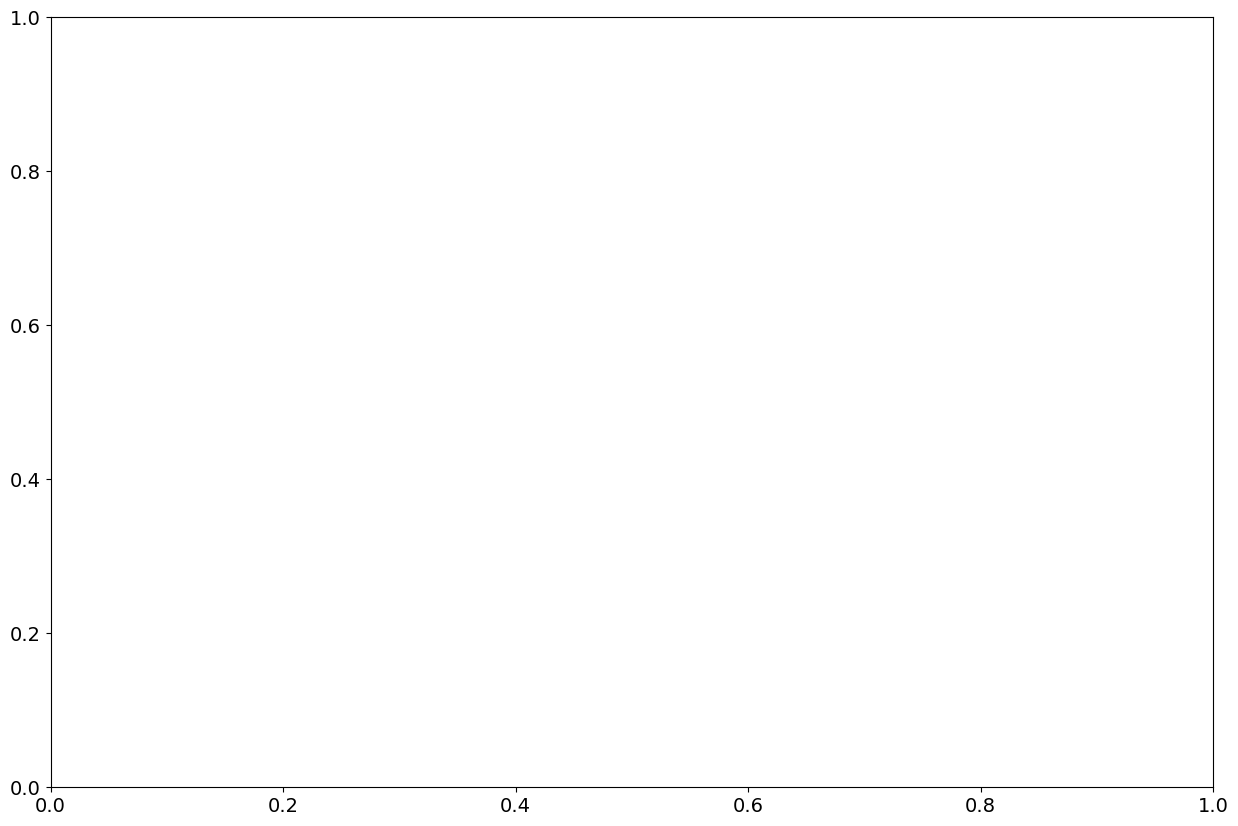

In [26]:
from lightgbm import LGBMClassifier, plot_importance, plot_tree, create_tree_digraph

lgbm = LGBMClassifier(n_estimators=50)
lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=[(X_test, y_test)], verbose=False)
lgbm_pred = lgbm.predict(X_test)
lgbm_prob = lgbm.predict_proba(X_test)[:, 1]

print(f"train set acc: {lgbm.score(X_train, y_train):.3f}")
print(f"test set acc: {lgbm.score(X_test, y_test):.3f}")

fi = lgbm.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(lgbm)
plt.barh(fn, fi)
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(lgbm, ax=ax)
plt.show()

train set acc: 1.000
test set acc: 0.958


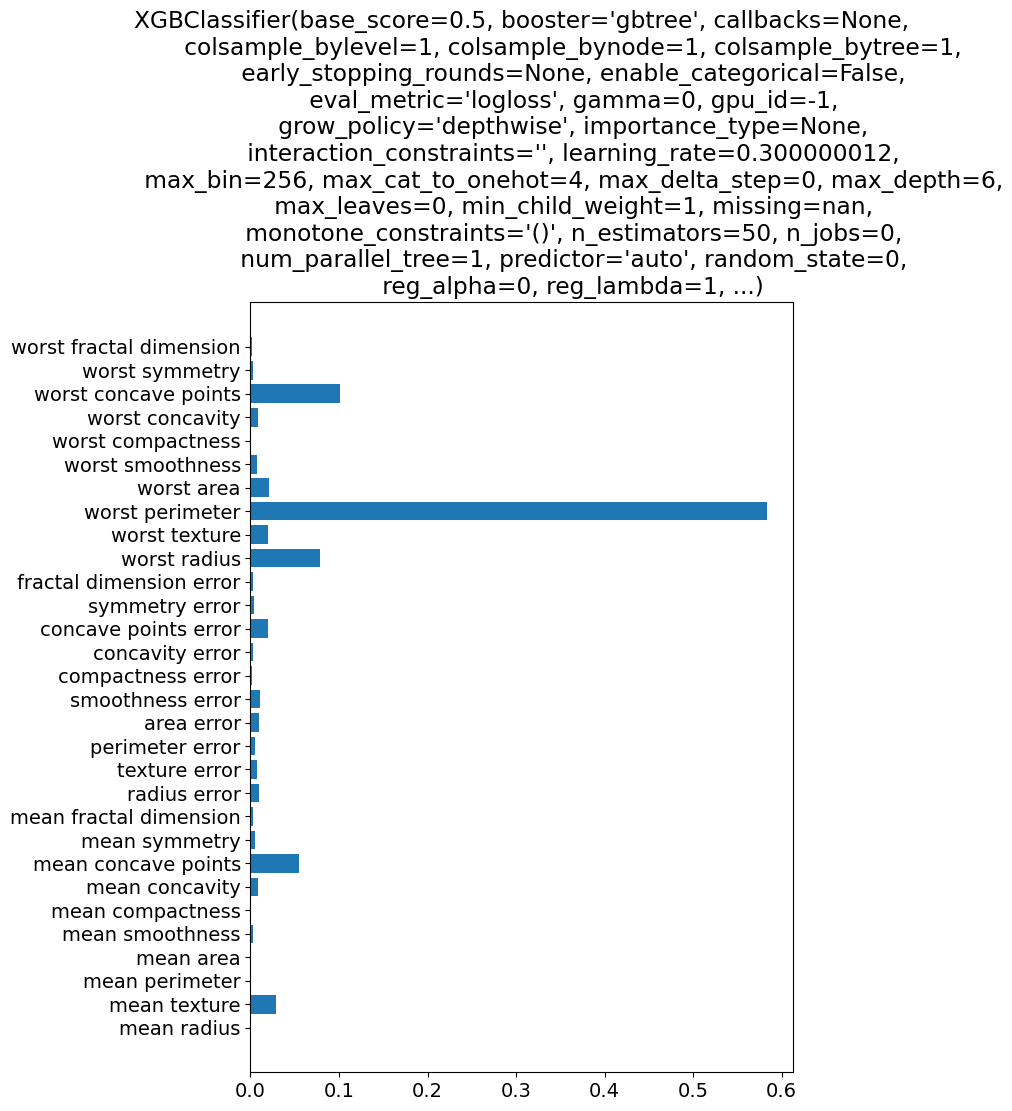

In [28]:
from xgboost import plot_importance, XGBClassifier

xg = XGBClassifier(objective='binary:logistic', n_estimators=50, eval_metric='logloss')
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
xg_pred = xg.predict(X_test)
xg_prob = xg.predict_proba(X_test)[:, 1]

print(f"train set acc: {xg.score(X_train, y_train):.3f}")
print(f"test set acc: {xg.score(X_test, y_test):.3f}")

fi = xg.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(xg)
plt.barh(fn, fi)
plt.show()


### 랜덤 포레스트와 Extra-trees
[랜덤 포레스트]
- 트리들이 서로 최대한 달라지도록 트리 생성 시 무작위성 주입 : 데이터 포인트를 부트스트랩 샘플링하고, 데이터의 특성을 무작위로 선택하여 구현
- 랜덤하게 선택한 일부 특성만으로 불순도 기준값ㅇ르 최소화하는 분할지점 결정 => 무작위성 증가 & 트레이닝 속도 증가
- 부스팅과 달리 병렬로 실행이 가능하고, 피쳐 개수가 적기 때문에 계산비용 낮음
- OOB데이터를 활용하여 추가적인 데이터 없이 모델 검증
- 매개변수 튜닝이 많이 하지 않아도 되며, 데이터 스케일 맞출 필요도 없다
- 결과에 대한 직관적 해석 불가능하며, 고차원의 희소한 데이터에는 잘 작동하지 않ㅇ흠

[Extra-trees(ERT, Extremely randomized tree)]
- 랜덤포레스트와 거의 같은 방법이나, 가지를 분할할 때 각 특징으로 데이터를 가장 잘 분할할 수 있는 임곗값 대신 랜덤 설정한 임곗값 이용
- 계산비용이 비교적 적지만, 무작위 분할로 인하여 일반화 성능을 위해 더 많은 트리 필요

train set acc: 1.000
test set acc: 0.944


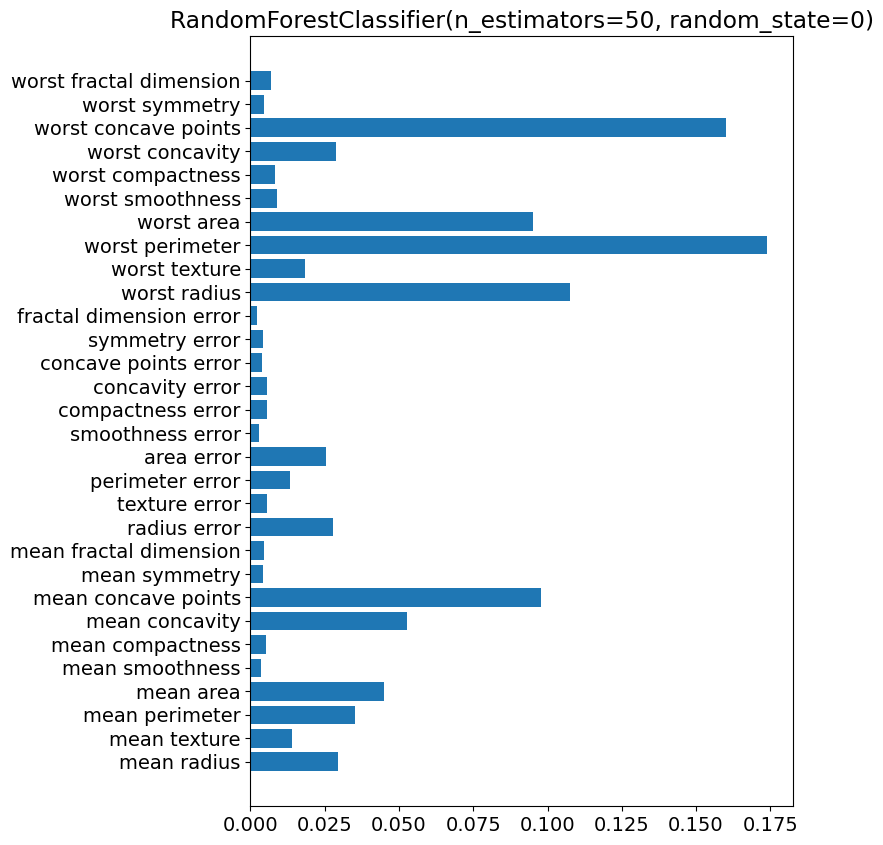

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

print(f"train set acc: {rf.score(X_train, y_train):.3f}")
print(f"test set acc: {rf.score(X_test, y_test):.3f}")

fi = rf.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(rf)
plt.barh(fn, fi)
plt.show()


train set acc: 1.000
test set acc: 0.944


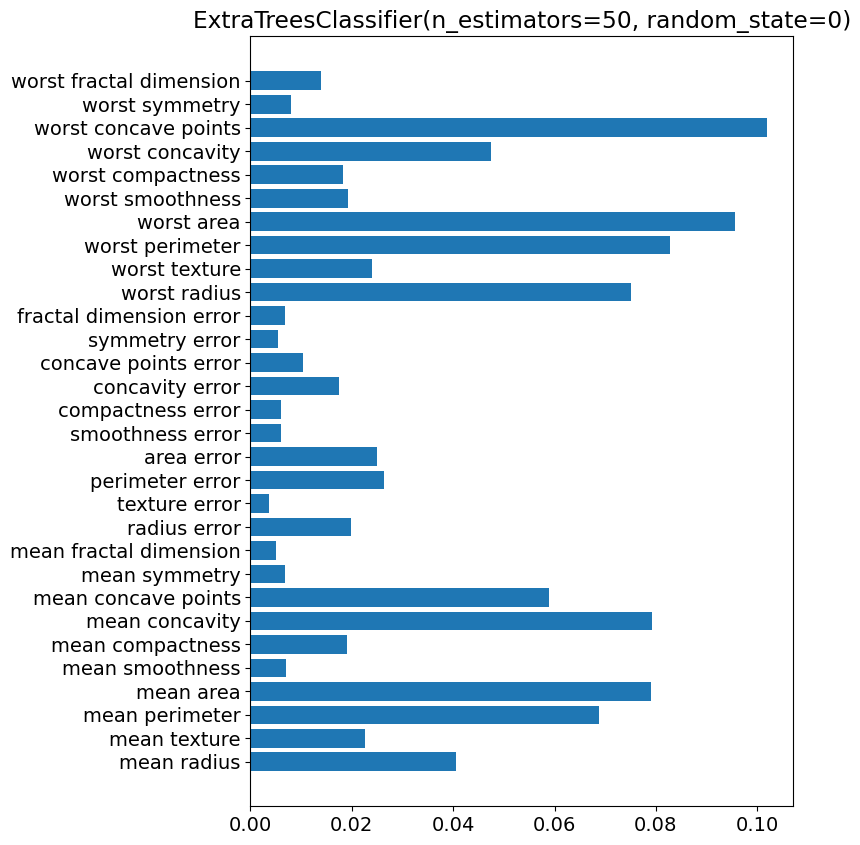

In [31]:
from sklearn.ensemble import ExtraTreesClassifier

xtree = ExtraTreesClassifier(n_estimators=50, random_state=0)
xtree.fit(X_train, y_train)
xtree_pred = xtree.predict(X_test)
xtree_prob = xtree.predict_proba(X_test)[:, 1]

print(f"train set acc: {xtree.score(X_train, y_train):.3f}")
print(f"test set acc: {xtree.score(X_test, y_test):.3f}")

fi = xtree.feature_importances_
fn = cancer.feature_names
fig, ax = plt.subplots(figsize=(7,10))
plt.title(xtree)
plt.barh(fn, fi)
plt.show()


### 스태킹
- 각 모델로부터 얻은 예측값을 데이터로 삼아 한번 더 모델링

In [32]:
titles = ['bagging', 'adaboost', 'gboost', 'lgbm', 'xgboost', 'rf' , 'xtree']
preds = [bagging_pred, ada_pred, gbc_pred, lgbm_pred, xg_pred, rf_pred, xtree_pred]
probs = [bagging_prob, ada_prob, gbc_prob, lgbm_prob, xg_prob, rf_prob, xtree_prob]

probs_df = pd.DataFrame(probs).T
meta_learner = RandomForestClassifier(n_estimators=30, random_state=0, max_depth=3)
meta_learner.fit(probs_df, y_test)
meta_learner.fit(probs_df, y_test)
meta_learner_pred = meta_learner.predict(probs_df)

from sklearn.metrics import accuracy_score

for title, pred, in zip(titles, preds):
    score = accuracy_score(y_test, pred)
    print(f"{title} score: {score:.3f}")

print(f"**stacking score: {accuracy_score(meta_learner_pred, y_test):.3f}")

bagging score: 0.923
adaboost score: 0.944
gboost score: 0.951
lgbm score: 0.923
xgboost score: 0.958
rf score: 0.944
xtree score: 0.944
**stacking score: 0.972
